In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

## Steps
1. Join the kaggle contest - https://www.kaggle.com/competitions/planttraits2024
2. Install kaggle cli - https://github.com/Kaggle/kaggle-api/blob/main/docs/README.md
3. Download the data - `kaggle competitions download -c planttraits2024`
4. Unzip the data
5. Install FGVC repo - `pip install -e .` and `pip install -r requirement.txt` in the desired env
5. Train the model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import omegaconf
import hydra
from lightning import Callback, LightningDataModule, LightningModule, Trainer
from omegaconf import DictConfig
from sklearn.preprocessing import StandardScaler

## Setup train metadata

In [3]:
df_train = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_train.csv')
cfg = omegaconf.OmegaConf.load("/home/ubuntu/FGVC11/configs/data/plant_traits_data.yaml")
datamodule: LightningDataModule = hydra.utils.instantiate(cfg)
datamodule.setup()

In [4]:
label_col = datamodule.data_train.class_names
aux_col = datamodule.data_train.aux_class_names
metadata_col = list(set(df_train.columns) - set(label_col) - set(aux_col) - set(["path", "id"]))
len(label_col), len(aux_col), len(metadata_col)

(6, 6, 163)

## Pre-process the data 

(55489, 177)
(49009, 177)


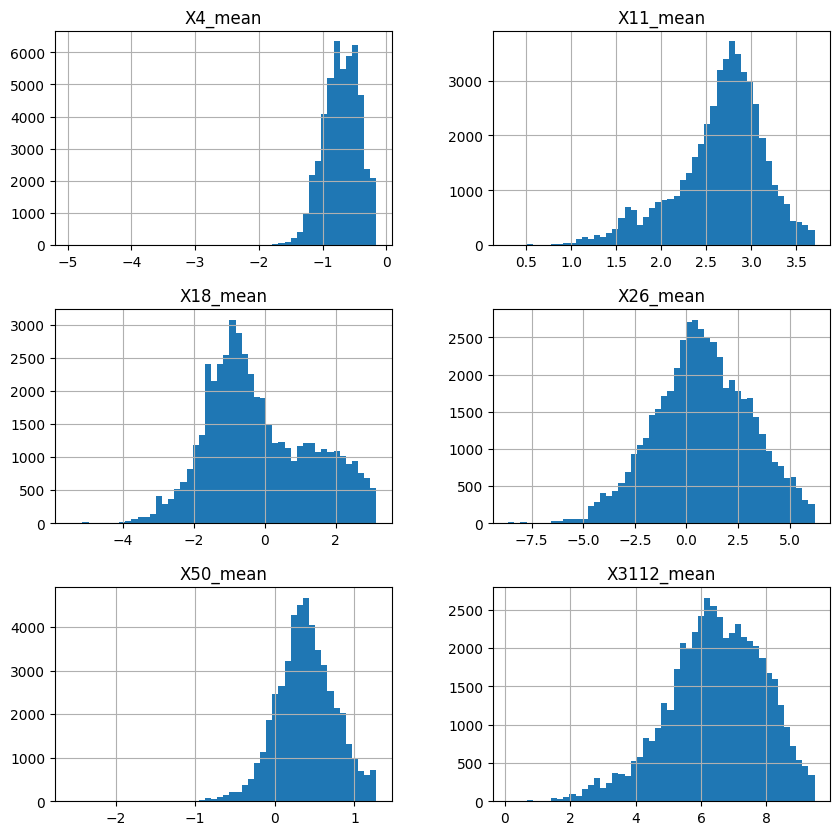

In [5]:
# preprocess the labels
df_train = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_train.csv')
print(df_train.shape)
df_train = df_train.dropna(subset=(label_col + metadata_col))
for column in label_col:
    upper_quantile = df_train[column].quantile(0.98)  
    df_train = df_train[(df_train[column] < upper_quantile)]
    df_train = df_train[(df_train[column] > 0)]   
    df_train[column] = np.log(df_train[column]) 
print(df_train.shape)
df_train[label_col].hist(bins=50, figsize=(10, 10))
plt.show()

In [6]:
# normalize the metadata
original_means = {}
original_stds = {}

for column in metadata_col:
    # Calculate the mean and standard deviation for each column
    original_means[column] = df_train[column].mean()
    original_stds[column] = df_train[column].std()

    df_train[column] = (df_train[column] - original_means[column]) / original_stds[column]

### Adding CLIP feats

In [7]:
# import torch
# import clip
# from PIL import Image
# from tqdm import tqdm
# import torchvision.transforms as transforms

# device = "cuda" if torch.cuda.is_available() else "cpu"
# # model, preprocess = clip.load("ViT-B/32", device=device)
# model = torch.hub.load(
#             "facebookresearch/dinov2", "dinov2_vits14_reg", pretrained=True
#         )
# model.to(device);

# # Define the transformations
# transform = transforms.Compose([
#     transforms.Resize((490, 490)),  # Resize the image to a fixed size
#     transforms.ToTensor(),  # Convert the image to a tensor
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
# ])

# feats = []
# for _, row in tqdm(df_train.iterrows(), total=len(df_train)):
#     image = transform(Image.open(row["path"])).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model(image.to(device))
#         feats.append(image_features.view(-1).cpu().numpy())
#     # break

# feats = np.array(feats)
# # np.save("feats.npy", feats)  

In [8]:
feats = np.load("feats.npy")
feats.shape

(49009, 512)

## Generate test data

In [9]:

df_test = pd.read_csv('/home/ubuntu/FGVC11/data/PlantTrait/df_test.csv')

for column in metadata_col:
    # Calculate the mean and standard deviation for each column
    mean = original_means[column] #df_test[column].mean()
    std = original_stds[column] #df_test[column].std()
    df_test[column] = (df_test[column] - mean) / std

# test_feats = []
# for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
#     image = transform(Image.open(row["path"])).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model(image.to(device))
#         test_feats.append(image_features.view(-1).cpu().numpy())

# save test feats
# test_feats = np.array(test_feats)
# #np.save("test_feats.npy", test_feats)  

test_feats = np.load("test_feats.npy")
test_feats.shape

(6545, 512)

## Run XGBoost

In [10]:
# create the training data
X = np.concatenate([df_train[metadata_col].values, feats], axis=1)
X.shape

(49009, 675)

In [11]:
# add clip feaures and save the final test data
x_final = np.concatenate([df_test[metadata_col].values, test_feats], axis=1)
dx_final = xgb.DMatrix(x_final, enable_categorical=False)
# Create a DataFrame with the corresponding IDs
submission_df = pd.DataFrame({
    'id': df_test['id'].values,
})


In [12]:
y = df_train[label_col].values
# Normalize the target
SCALER = StandardScaler()
y = SCALER.fit_transform(y)

### For all the traits simultaneously

In [ ]:
results = []
# get 5 models
for i in range(5):
    y = df_train[label_col].values

    # Normalize the target
    SCALER = StandardScaler()
    y = SCALER.fit_transform(y)

    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=i, test_size=0.2)
    print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

    # Create regression matrices
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
    dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=False)

    # set hyperparams
    params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", "max_depth":3}
    n = 1000

    evals = [(dval_reg, "validation")]

    model = xgb.train(
        params=params,
        dtrain=dtrain_reg,
        num_boost_round=n,
        evals=evals,
        verbose_eval=10,
        # Activate early stopping
        early_stopping_rounds=10
        )

    print("*"*100)
    y_train_pred = model.predict(dtrain_reg)
    y_train_pred = np.exp(SCALER.inverse_transform(y_train_pred))
    y_train = np.exp(SCALER.inverse_transform(y_train))
    print(f"R2 train: {r2_score(y_train, y_train_pred)}")

    y_val_pred = model.predict(dval_reg)
    y_val_pred = np.exp(SCALER.inverse_transform(y_val_pred))
    y_val = np.exp(SCALER.inverse_transform(y_val))
    print(f"R2 val : {r2_score(y_val, y_val_pred)}")

    sub_cols = [i.replace("_mean", "") for i in label_col]
    y_final = model.predict(dx_final)
    y_final = np.exp(SCALER.inverse_transform(y_final))
    submission_df[sub_cols] = y_final
        
    # compare with a good submission from kaggle to sanity check
    sub = pd.read_csv('submission_good.csv')
    print("R2 with good", r2_score(sub[sub.columns[1:]], submission_df[sub.columns[1:]]))
    print("*"*100)

    results.append(submission_df.copy())


In [16]:
sub_final_df = results[0]
for tmp_df in results[1:]:
    sub_final_df[sub_cols] += tmp_df[sub_cols]
sub_final_df[sub_cols] /= len(results)
sub = pd.read_csv('submission_good.csv')
print("R2 with good", r2_score(sub[sub.columns[1:]], sub_final_df[sub.columns[1:]]))

R2 with good 0.4585514093878877


In [17]:
sub_final_df.to_csv("submission.csv", index=False)

### For each trait separately

In [ ]:
# for col in label_col:
#     y = df_train[col].values

#     # Normalize the target
#     SCALER = StandardScaler()
#     y = SCALER.fit_transform(y.reshape(-1, 1)).flatten()

#     # Split the data
#     X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=9450, test_size=0.2)
#     print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

#     # Create regression matrices
#     dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=False)
#     dval_reg = xgb.DMatrix(X_val, y_val, enable_categorical=False)
    
#     # set hyperparams
#     params = {"objective": "reg:squarederror", "tree_method": "gpu_hist", "max_depth":3}
#     n = 1000

#     evals = [(dval_reg, "validation")]

#     model = xgb.train(
#         params=params,
#         dtrain=dtrain_reg,
#         num_boost_round=n,
#         evals=evals,
#         verbose_eval=5,
#         # Activate early stopping
#         early_stopping_rounds=5
#         )

#     print("*"*100)
#     y_train_pred = model.predict(dtrain_reg)
#     y_train_pred = np.exp(SCALER.inverse_transform(y_train_pred.reshape(-1, 1)))
#     y_train = np.exp(SCALER.inverse_transform(y_train.reshape(-1, 1)))
#     print(f"R2 train {col}: {r2_score(y_train, y_train_pred)}")
    
#     y_val_pred = model.predict(dval_reg)
#     y_val_pred = np.exp(SCALER.inverse_transform(y_val_pred.reshape(-1, 1)))
#     y_val = np.exp(SCALER.inverse_transform(y_val.reshape(-1, 1)))
#     print(f"R2 val {col} : {r2_score(y_val, y_val_pred)}")


#     y_final = model.predict(dx_final)
#     y_final = np.exp(SCALER.inverse_transform(y_final.reshape(-1, 1)))
#     submission_df[col.replace("_mean", "")] = y_final
#     print("*"*100)    
#     # break
# # compare with a good submission from kaggle to sanity check
# sub = pd.read_csv('submission_good.csv')
# r2_score(sub[sub.columns[1:]], submission_df[sub.columns[1:]])

In [ ]:
submission_df.hist(bins=50, figsize=(10, 10))
plt.show()

In [ ]:
# make sure columns are in right order, otherwise you'll get absurd values
submission_df[sub.columns].to_csv('submission.csv', index=False)

In [18]:
!kaggle competitions submit -c planttraits2024 -f submission.csv -m "xgboost with clip features and metadata merged 5"

100%|█████████████████████████████████████████| 447k/447k [00:01<00:00, 396kB/s]
Successfully submitted to PlantTraits2024 - FGVC11